## Experiment forecasting using LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                39424     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 42,134
Trainable params: 42,134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
28/28 - 4s - loss: 0.1227 - mse: 0.1227 - val_loss: 0.0605 - val_mse: 0.0605 - 4s/epoch - 125ms/step
Epoch 2/50
28/28 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0154 

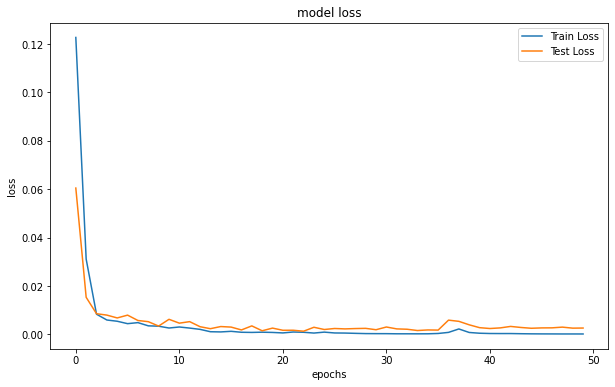

61/61 [==============================] - 0s 6ms/step
MSE:  0.000506292835350744
RMSE:  0.022500951876548332
Coefficient of determination (r2 Score):  0.9795307049464705


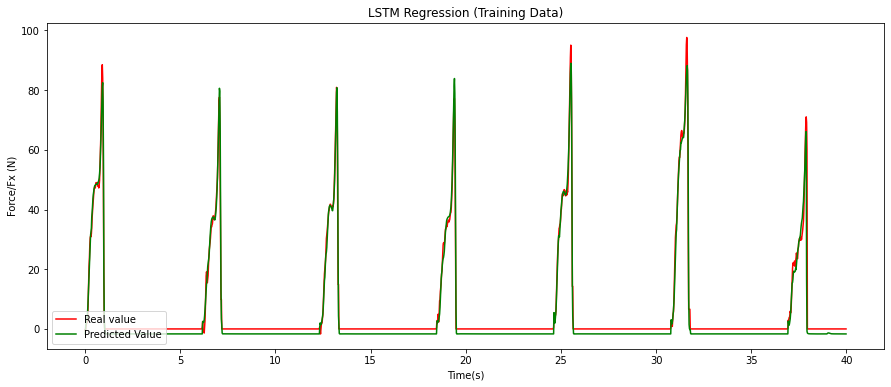

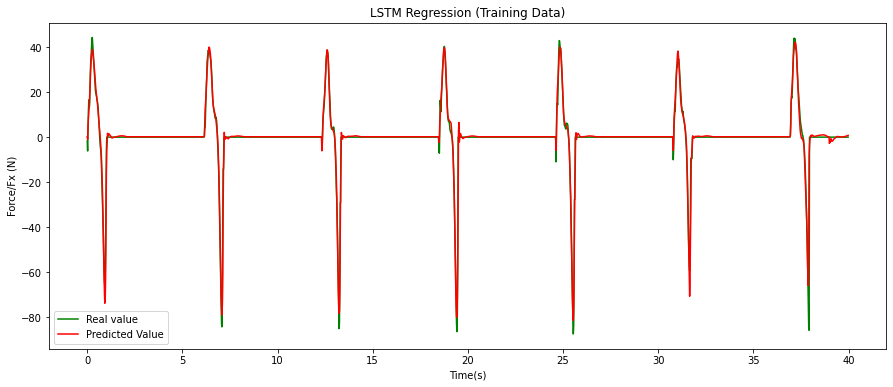

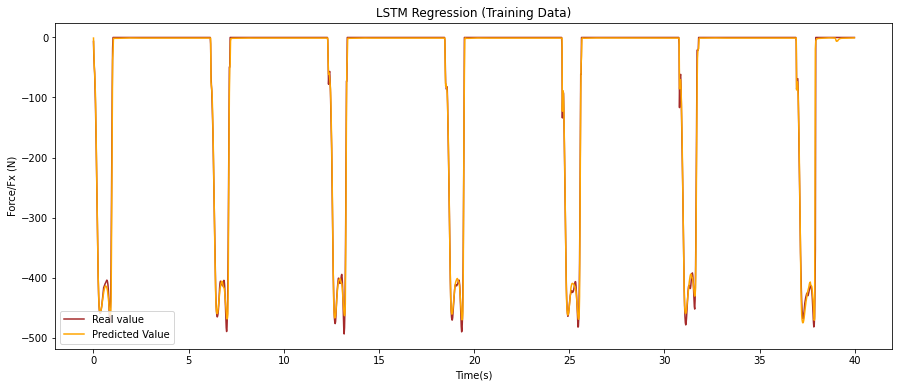

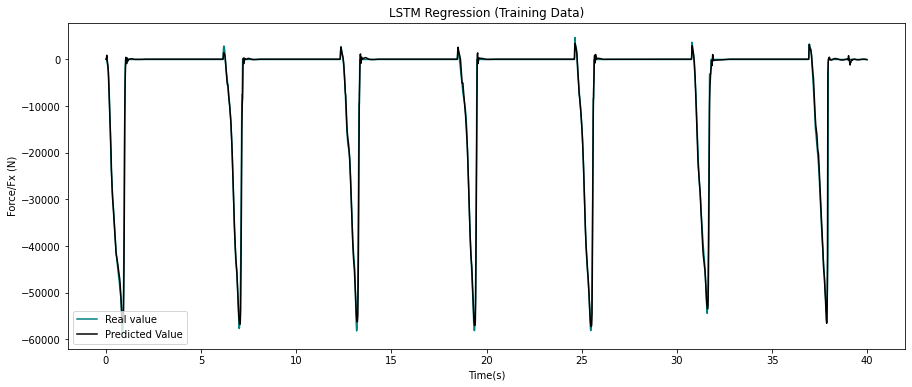

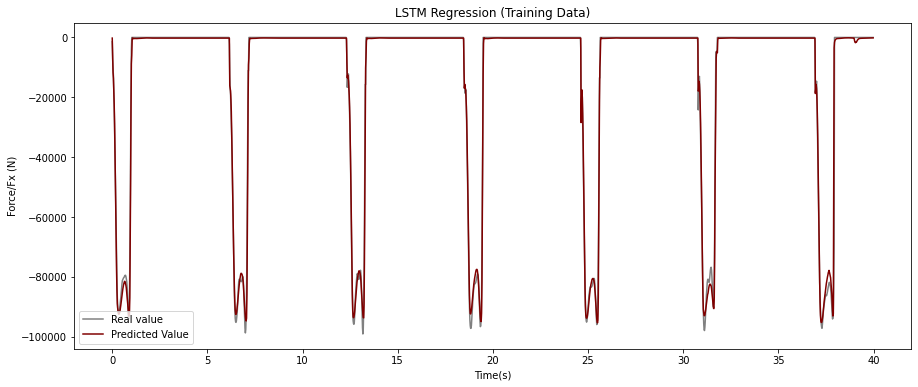

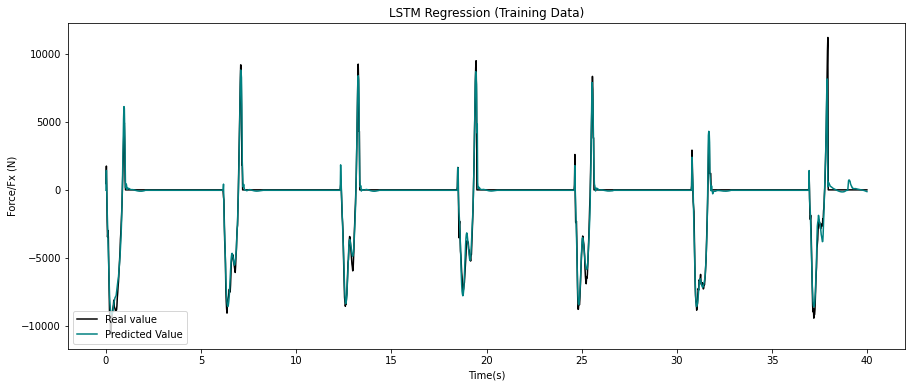

61/61 [==============================] - 0s 7ms/step


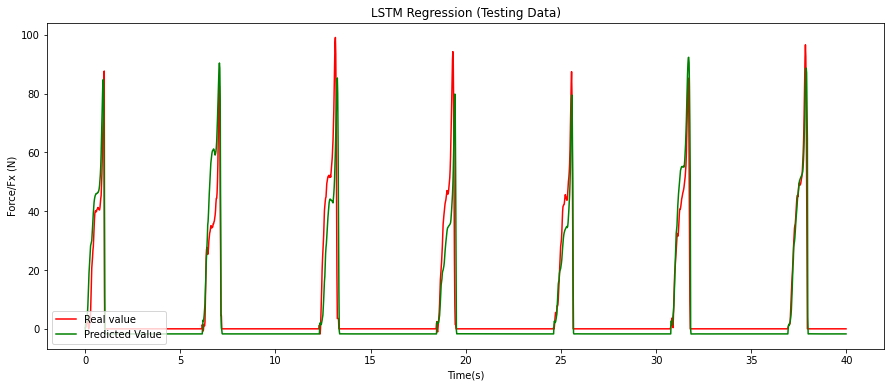

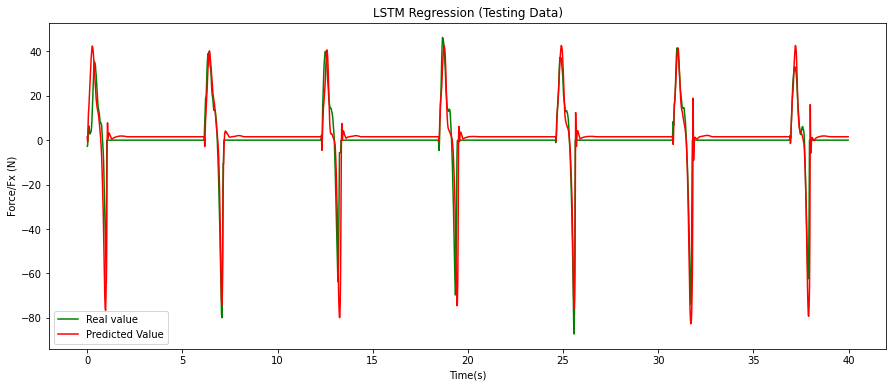

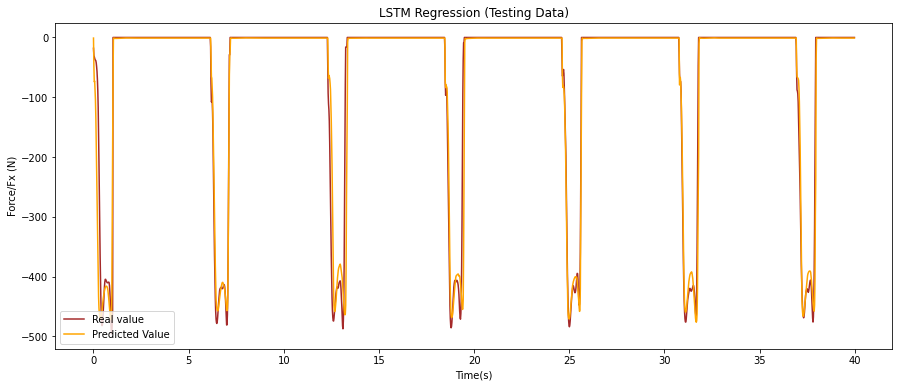

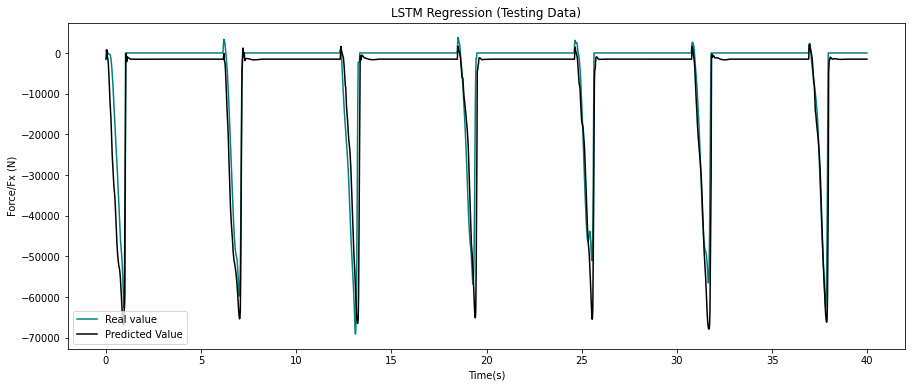

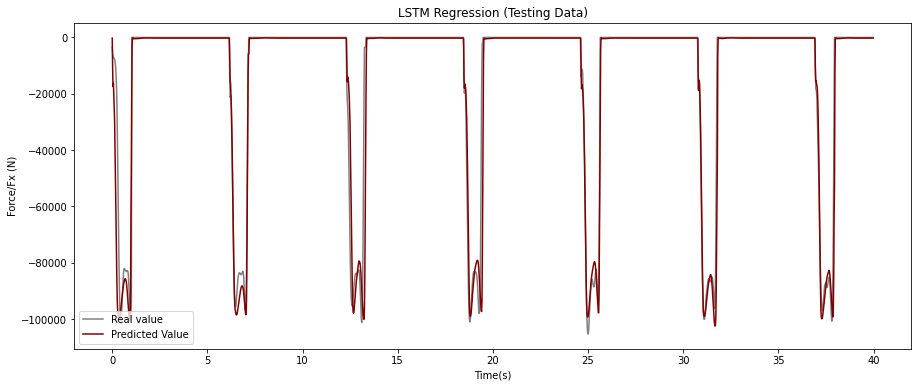

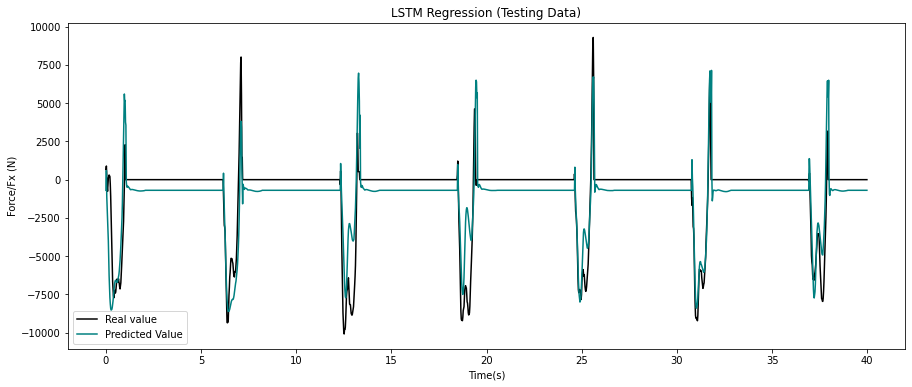

In [2]:
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

## Load Data
Insole = pd.read_csv('1113_Rwalk40s1_list.txt', header=None, low_memory=False)
SIData =  np.asarray(Insole)

df = pd.read_csv('1113_Rwalk40s1.csv', low_memory=False)
columns = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
selected_df = df[columns]
FCDatas = selected_df[:2050]
## End Load Data

## Concatenate Data
SmartInsole = np.array(SIData[:2050])
FCData = np.array(FCDatas)
# FCData = np.where(FCData>0, 0, FCData)
Dataset = np.concatenate((SmartInsole, FCData), axis=1)
## End Concatenate Data


## Normalization Data
scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))
data_scaled_in = scaler_in.fit_transform(Dataset[:,0:89])
data_scaled_out = scaler_out.fit_transform(Dataset[:,89:95])
## End Normalization Data

steps= 50
inp = []
out = []
for i in range(len(data_scaled_out) - (steps)):
    inp.append(data_scaled_in[i:i+steps])
    out.append(data_scaled_out[i+steps])

inp= np.asanyarray(inp)
out= np.asanyarray(out)

x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.10,random_state=2)

## Model Building
model = Sequential()
model.add(LSTM(64, activation='relu',  return_sequences= False, input_shape= (50,89)))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss = 'mse', optimizer=Adam(learning_rate=0.002), metrics=['mse'])
model.summary()
## End Model Building

## Model fit
history = model.fit(x_train,y_train, epochs=50, verbose=2, batch_size=64, validation_data=(x_test, y_test), shuffle=True)
## End Model fit

## Model Loss Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()
## End Model Loss Plot

## Prediction and Model Evaluation
model.evaluate(inp, out)
predictions=model.predict(inp)

print('MSE: ',mean_squared_error(out, predictions))
print('RMSE: ',math.sqrt(mean_squared_error(out, predictions)))
print('Coefficient of determination (r2 Score): ', r2_score(out, predictions))

#invert normalize
predictions = scaler_out.inverse_transform(predictions) 
out = scaler_out.inverse_transform(out) 

x=[]
colors=['red','green','brown','teal','gray','black','maroon','orange','purple']
colors2=['green','red','orange','black','maroon','teal','blue','gray','brown']
x = np.arange(0,1950)*40/1950 
for i in range(0,6):
    plt.figure(figsize=(15,6))
    plt.plot(x,out[0:1950,i],color=colors[i])
    plt.plot(x,predictions[0:1950,i],markerfacecolor='none',color=colors2[i])
    plt.title('LSTM Regression (Training Data)')
    plt.ylabel('Force/Fx (N)')
    plt.xlabel('Time(s)')
    plt.legend(['Real value', 'Predicted Value'], loc='lower left')
    plt.savefig('Regression Result.png'[i])
    plt.show()

## End Prediction and Model Evaluation

## Model Validation
Test_Insole = pd.read_csv('1113_Rwalk40s2_list.txt', header=None, low_memory=False)
TestSIData =  np.asarray(Test_Insole)

Test_df = pd.read_csv('1113_Rwalk40s2.csv', low_memory=False)
Test_columns = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
Test_selected_df = Test_df[Test_columns]
Test_FCDatas = Test_selected_df[:2050]

test_SmartInsole = np.array(TestSIData[:2050])
test_FCData = np.array(Test_FCDatas)
# test_FCData = np.where(test_FCData>0, 0, test_FCData)
test_Dataset = np.concatenate((test_SmartInsole, test_FCData), axis=1)

test_scaler_in = MinMaxScaler(feature_range=(0, 1))
test_scaler_out = MinMaxScaler(feature_range=(0, 1))
test_data_scaled_in = test_scaler_in.fit_transform(test_Dataset[:,0:89])
test_data_scaled_out = test_scaler_out.fit_transform(test_Dataset[:,89:95])

test_steps= 50
test_inp = []
test_out = []
for i in range(len(test_data_scaled_out) - (test_steps)):
    test_inp.append(test_data_scaled_in[i:i+test_steps])
    test_out.append(test_data_scaled_out[i+test_steps])

test_inp= np.asanyarray(test_inp)
test_out= np.asanyarray(test_out)

model.evaluate(test_inp, test_out)
test_predictions=model.predict(test_inp)

test_predictions = test_scaler_out.inverse_transform(test_predictions) 
test_out = test_scaler_out.inverse_transform(test_out) 

x=[]
colors=['red','green','brown','teal','gray','black','maroon','orange','purple']
colors2=['green','red','orange','black','maroon','teal','blue','gray','brown']
x = np.arange(0,1950)*40/1950 
for i in range(0,6):
    plt.figure(figsize=(15,6))
    plt.plot(x,test_out[0:1950,i],color=colors[i])
    plt.plot(x,test_predictions[0:1950,i],markerfacecolor='none',color=colors2[i])
    plt.title('LSTM Regression (Testing Data)')
    plt.ylabel('Force/Fx (N)')
    plt.xlabel('Time(s)')
    plt.legend(['Real value', 'Predicted Value'], loc='lower left')
    plt.savefig('Regression Result.png'[i])
    plt.show()

## End Model validation